In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

## General Setup

In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open("id2label_dicts/category_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


In [4]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cuda | SG2 device: cuda | General device: cuda


## Fixed Models Setup

In [5]:
# Products data and latents
target_feature = 'category'
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier = load_classifier()
classifier = classifier.to(device)

In [6]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [7]:
# Print devoce for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: cuda:0 | Requires Grad: False
DinoV2: cuda:0 | Requires Grad: False
Classifier: cuda:0 | Requires Grad: False


In [8]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

In [9]:
z = torch.randn(1,512, device = sg2_device)
img_gen = G(z, None)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/dinov2/lib/python3.9/site-packages/torch/utils/cpp_extension.py", line 1306, in load
    return _jit_compile(
  File "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/

### Test on small sample

In [ ]:
id2label

In [ ]:
target_class = 5
num_refinement_steps = 40
num_train_samples = 10

# Initialize Directions Matrix as zeros
directions = torch.zeros([8, 16, 512], device=device, requires_grad=True)
alpha = 0.5

# Set up optimizer and loss
optimizer = torch.optim.Adam([directions], lr=1e-2)
loss = nn.MSELoss(reduction='sum')

# Draw random training sample
samples = np.random.choice(range(0,len(latents)), 10)
for sample in tqdm(samples):
    print(f"Sample index: {sample}")
    latent = latents[sample]
    # Get class prediction for target class of unedited latent
    with io.capture_output() as captured:
        orig = G.synthesis(latent, noise_mode='const')
    orig_input_dino = dino_processor(orig).to(dino_device)
    orig_embedding = dino_model(orig_input_dino)['pooler_output'].to(device)
    orig_score = softmax(classifier(orig_embedding), dim = 1).squeeze(0)
    orig_score = orig_score[target_class]
    target_score = orig_score + alpha
    print(f"\tOriginal Score: {orig_score.item()} \n\tTarget Score: {target_score}")

    # Keep track of refinement steps
    out_images = [plot_generated(orig)]
    out_scores = [orig_score.cpu().item()]
    # Refine the directions using gradient descent on one image only
    for i in tqdm(range(num_refinement_steps), leave = False):
        optimizer.zero_grad()
        new_latent = latent + alpha * directions[target_class]
        with io.capture_output() as captured:
            new_img = G.synthesis(new_latent, noise_mode='const')
        plot_img = plot_generated(new_img)
        input_dino = dino_processor(new_img).to(dino_device)
        embedding = dino_model(input_dino)['pooler_output'].to(device)
        score = softmax(classifier(embedding), dim = 1).squeeze(0)
        score = score[target_class]

        # Calculate loss and propagate backwards
        l = loss(target_score, score)
        l.backward()
        optimizer.step()
        
        # Keep track of generated image every n steps
        if i % 5 == 0:
            out_images.append(plot_generated(new_img))
            out_scores.append(score.cpu().item())
    
    # Plot the refinement progress for one image
    fig, ax = plt.subplots(1, len(out_images), figsize=(len(out_images)*2,3))
    for v, image in enumerate(out_images):
        ax[v].imshow(image)
        ax[v].axis('off')
        ax[v].set_title(f'Class Score: {np.round(out_scores[v], 3)}')
    plt.show()


In [ ]:
# Visualize samples and direction manipulations
num_samples = 10
samples = np.random.choice(range(0,len(latents)), num_samples)
fig, ax = plt.subplots(num_samples, 4, figsize=(20, 20))
for i, sample in enumerate(tqdm(samples)):
    latent = latents[sample]
    with io.capture_output() as captured:
        orig_img = G.synthesis(latent, noise_mode='const')
    new_latent_1 = latent + 0.5 * directions[target_class]
    new_latent_2 = latent + 1.0 * directions[target_class]
    new_latent_3 = latent + 1.5 * directions[target_class]
    with io.capture_output() as captured:
        new_img_1 = G.synthesis(new_latent_1, noise_mode='const')
        new_img_2 = G.synthesis(new_latent_2, noise_mode='const')
        new_img_3 = G.synthesis(new_latent_3, noise_mode='const')

    ax[i, 0].imshow(plot_generated(orig_img))
    ax[i, 1].imshow(plot_generated(new_img_1))
    ax[i, 2].imshow(plot_generated(new_img_2))
    ax[i, 3].imshow(plot_generated(new_img_3))
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 0].set_title(f"Original")
    ax[i, 1].set_title(f"Alpha = 0.5")
    ax[i, 2].set_title(f"Alpha = 1.0")
    ax[i, 3].set_title(f"Alpha = 1.5")

plt.tight_layout()
fig.suptitle('Apply Learned Directions on Random Test Images')
plt.show()

### Train on all classes and many samples

  0%|          | 0/150 [00:00<?, ?it/s]

Sample index: 7270, Target Class: 7
	Original Score: 4.6265307673820644e-07 
	Target Score: 0.30000048875808716 
	Alpha: 0.3


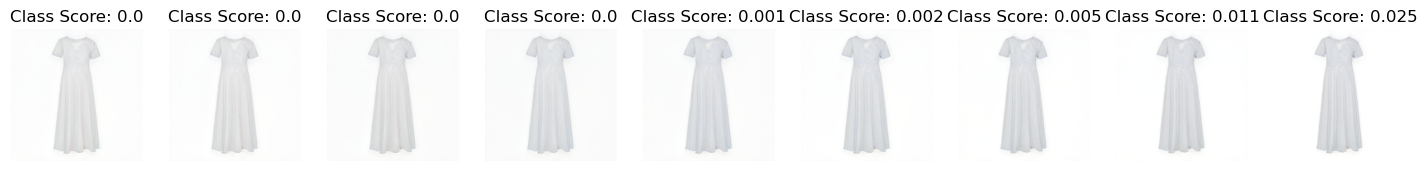

Sample index: 3556, Target Class: 4
	Original Score: 0.9391735792160034 
	Target Score: 1.0 
	Alpha: 0.06082642078399658


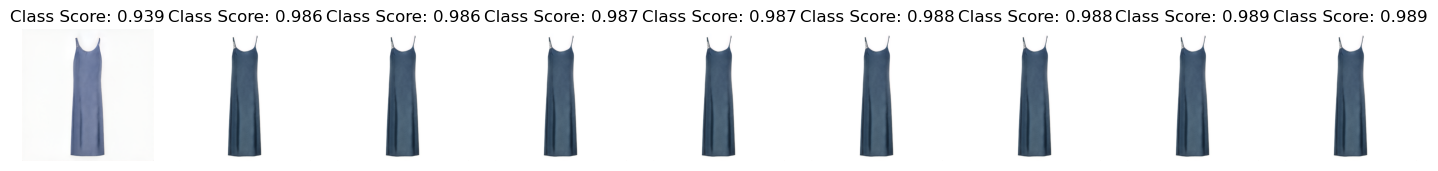

Sample index: 1016, Target Class: 0
	Original Score: 0.5665944218635559 
	Target Score: 0.6665944457054138 
	Alpha: 0.1


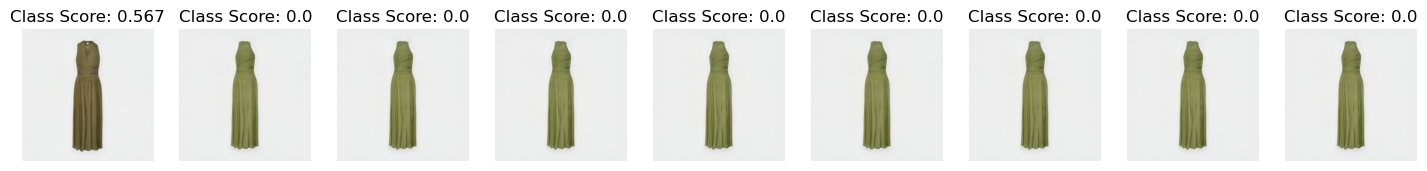

In [10]:
num_refinement_steps = 40
num_train_samples = 150
print_interval = 50
save_interval = 50
resume_from_checkpoint = False
checkpoint_path = f"{DATA_PATH}/Models/Manipulations/GANalyze_Inspired/directions_step_15.pt"

# Initialize Directions Matrix as zeros
if not resume_from_checkpoint:
    directions = torch.zeros([8, 16, 512], device=device, requires_grad=True)
elif resume_from_checkpoint: 
    directions = torch.load(checkpoint_path)

# Set up optimizer and loss
optimizer = torch.optim.Adam([directions], lr=1e-2)
loss = nn.MSELoss(reduction='sum')

# Draw random training sample
samples = np.random.choice(range(0,len(latents)), num_train_samples)
for sample_num, sample in enumerate(tqdm(samples)):

    # Sample random target class:
    target_class = np.random.choice(list(id2label.keys()))
    # Sample random alpha in range -0.5,0.5
    alpha = np.random.choice(np.round(np.arange(0.1, 0.6, 0.1),2))

    if sample_num % print_interval == 0:
        print(f"Sample index: {sample}, Target Class: {target_class}")
    latent = latents[sample]
    # Get class prediction for target class of unedited latent
    with io.capture_output() as captured:
        orig = G.synthesis(latent, noise_mode='const')
    orig_input_dino = dino_processor(orig).to(dino_device)
    orig_embedding = dino_model(orig_input_dino)['pooler_output'].to(device)
    orig_score = softmax(classifier(orig_embedding), dim = 1).squeeze(0)
    orig_score = orig_score[target_class]

    # Calculate Target score and handle non-existent probabilities
    if orig_score + alpha >= 1.0:
        alpha = 1.0 - orig_score
    elif orig_score + alpha  <= 0:
        alpha = -orig_score

    target_score = orig_score + alpha
    if sample_num % print_interval == 0:
        print(f"\tOriginal Score: {orig_score.item()} \n\tTarget Score: {target_score} \n\tAlpha: {alpha}")

    # Keep track of refinement steps
    if sample_num % print_interval == 0:
        out_images = [plot_generated(orig)]
        out_scores = [orig_score.cpu().item()]
    # Refine the directions using gradient descent on one image only
    for i in range(num_refinement_steps):
        optimizer.zero_grad()
        new_latent = latent + alpha * directions[target_class]
        with io.capture_output() as captured:
            new_img = G.synthesis(new_latent, noise_mode='const')
        plot_img = plot_generated(new_img)
        input_dino = dino_processor(new_img).to(dino_device)
        embedding = dino_model(input_dino)['pooler_output'].to(device)
        score = softmax(classifier(embedding), dim = 1).squeeze(0)
        score = score[target_class]

        # Calculate loss and propagate backwards
        l = loss(target_score, score)
        l.backward()
        optimizer.step()
        
        # Keep track of generated image every n steps
        if (i % 5 == 0) & (sample_num % print_interval == 0):
            out_images.append(plot_generated(new_img))
            out_scores.append(score.cpu().item())
    
    if sample_num % print_interval == 0:
        # Plot the refinement progress for one image
        fig, ax = plt.subplots(1, len(out_images), figsize=(len(out_images)*2,3))
        for v, image in enumerate(out_images):
            ax[v].imshow(image)
            ax[v].axis('off')
            ax[v].set_title(f'Class Score: {np.round(out_scores[v], 3)}')
        plt.show()
    
    if sample_num % save_interval == 0:
        torch.save(directions, f"{DATA_PATH}/Models/Manipulations/GANalyze_Inspired/directions_step_{sample_num}.pt")


### Test the Learned directions

In [13]:
directions = torch.load(f"{DATA_PATH}/Models/Manipulations/GANalyze_Inspired/directions_step_{150}.pt")

target_class = 0
# Visualize samples and direction manipulations
num_samples = 10
samples = np.random.choice(range(0,len(latents)), num_samples)
fig, ax = plt.subplots(num_samples, 4, figsize=(20, 20))
for i, sample in enumerate(tqdm(samples)):
    latent = latents[sample]
    with io.capture_output() as captured:
        orig_img = G.synthesis(latent, noise_mode='const')
    new_latent_1 = latent + 0.5 * directions[target_class]
    new_latent_2 = latent + 1.0 * directions[target_class]
    new_latent_3 = latent + 1.5 * directions[target_class]
    with io.capture_output() as captured:
        new_img_1 = G.synthesis(new_latent_1, noise_mode='const')
        new_img_2 = G.synthesis(new_latent_2, noise_mode='const')
        new_img_3 = G.synthesis(new_latent_3, noise_mode='const')

    ax[i, 0].imshow(plot_generated(orig_img))
    ax[i, 1].imshow(plot_generated(new_img_1))
    ax[i, 2].imshow(plot_generated(new_img_2))
    ax[i, 3].imshow(plot_generated(new_img_3))
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 0].set_title(f"Original")
    ax[i, 1].set_title(f"Alpha = 0.5")
    ax[i, 2].set_title(f"Alpha = 1.0")
    ax[i, 3].set_title(f"Alpha = 1.5")

plt.tight_layout()
fig.suptitle('Apply Learned Directions on Random Test Images')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

### Torch Model Class -> Needs to be fixed

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import numpy as np

class Editor(nn.Module):
    def __init__(self, generator, dino_model, dino_processor, classifier, id2label, label2id):
        super(Editor, self).__init__()
        self.generator = generator
        self.dino_model = dino_model
        self.dino_processor = dino_processor
        self.classifier = classifier

        self.id2label = id2label
        self.label2id = label2id   
        self.num_classes = len(id2label)
        self.directions = nn.Parameter(torch.zeros(self.num_classes, 16, 512), requires_grad=True)
        self.alphas = np.arange(0,1,0.1)

    def forward(self, latent, class_idx=None, alpha = None):
        if class_idx == None:
            class_idx = torch.randint(0, self.num_classes, (1,), device=self.directions.device)
        
        if alpha == None:
            alpha = torch.tensor(np.round(np.random.choice(self.alphas),2), device=latent.device, dtype=torch.float32)
            print(alpha)
        # Processing for real image
        with io.capture_output() as captured:
            real_img = self.generator.synthesis(latent, noise_mode='const')
        real_dino_input = self.dino_processor(real_img).to(dino_model.device)
        real_dino_embedding = self.dino_model(real_dino_input)['pooler_output'].to(latent.device)
        real_scores = self.classifier(real_dino_embedding)
        real_probs = softmax(real_scores, dim=1).squeeze(0)
        real_class_prob = real_probs[class_idx]

        # Processing for transformed image
        transformed_latent = latent + alpha * self.directions[class_idx].to(latent.device)
        with io.capture_output() as captured:
            transformed_img = self.generator.synthesis(transformed_latent, noise_mode='const')
        transformed_dino_input = self.dino_processor(transformed_img).to(dino_model.device)
        transformed_dino_embedding = self.dino_model(transformed_dino_input)['pooler_output'].to(latent.device)
        transformed_scores = self.classifier(transformed_dino_embedding)
        transformed_probs = softmax(transformed_scores, dim=1).squeeze(0)
        transformed_class_prob = transformed_probs[class_idx]

        return real_class_prob, transformed_class_prob, class_idx, alpha


In [ ]:
k = 9876

latent = latents[k]
display(df[df.latent_idx == k])
gen_img = G.synthesis(latent, noise_mode='const')
gen_img = plot_generated(gen_img)
display(gen_img)

In [ ]:
# Assuming all components are properly setup and moved to the correct device

latent = latents[k]

editor = Editor(G, dino_model, dino_processor, classifier, id2label, label2id)
optimizer = torch.optim.Adam(editor.parameters(), lr=0.5)
criterion = nn.MSELoss(reduction='sum')

for i in range(20):
    optimizer.zero_grad()
    real_class_prob, transformed_class_prob, class_idx, alpha = editor(latent, class_idx = 0, alpha=1)
    target = torch.tensor(1.0, device=latent.device, dtype=torch.float32)
    loss = criterion(target, transformed_class_prob)

    loss.backward()
    optimizer.step()
    print(f"Step {i} (class: {class_idx}, alpha:{alpha}): Loss: {loss.item()} | Directions gradient norm {editor.directions.grad.norm()} | Class prob of gen: {transformed_class_prob.item()}")
    transformed = latent + 1 * editor.directions[0].to(latent.device)
    out_img = plot_generated(G.synthesis(transformed, noise_mode='const'))
    display(out_img.resize([124, 124]))


In [ ]:
transformed_latent = latent + 1 * editor.directions[0].to(latent.device)
out_img = plot_generated(G.synthesis(transformed_latent, noise_mode='const')).resize([512, 512])
out_img

In [ ]:
# Test the classification: 
dino_input = dino_processor(G.synthesis(transformed_latent, noise_mode='const')).to(dino_model.device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)
probs = softmax(scores, dim=1).squeeze(0)
probs